<a href="https://colab.research.google.com/github/tej-o-droid/gold-price-prognostication-multiheaded-transformer/blob/main/GOLD_PRICE_PREDICTION_USING_TRANSFORMERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Training and test data have been saved to CSV files.
Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.6089 - val_loss: 0.0034
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - loss: 7.3030e-04 - val_loss: 6.8390e-04
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 5.9344e-04 - val_loss: 7.5064e-04
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 5.4683e-04 - val_loss: 6.5515e-04
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 4.2103e-04 - val_loss: 3.9974e-04
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 4.2481e-04 - val_loss: 0.0011
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 4.2005e-04 - val_loss: 4.5719e-04
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - loss: 3.4258e-04 - val_loss: 3.3982e-04
Epo

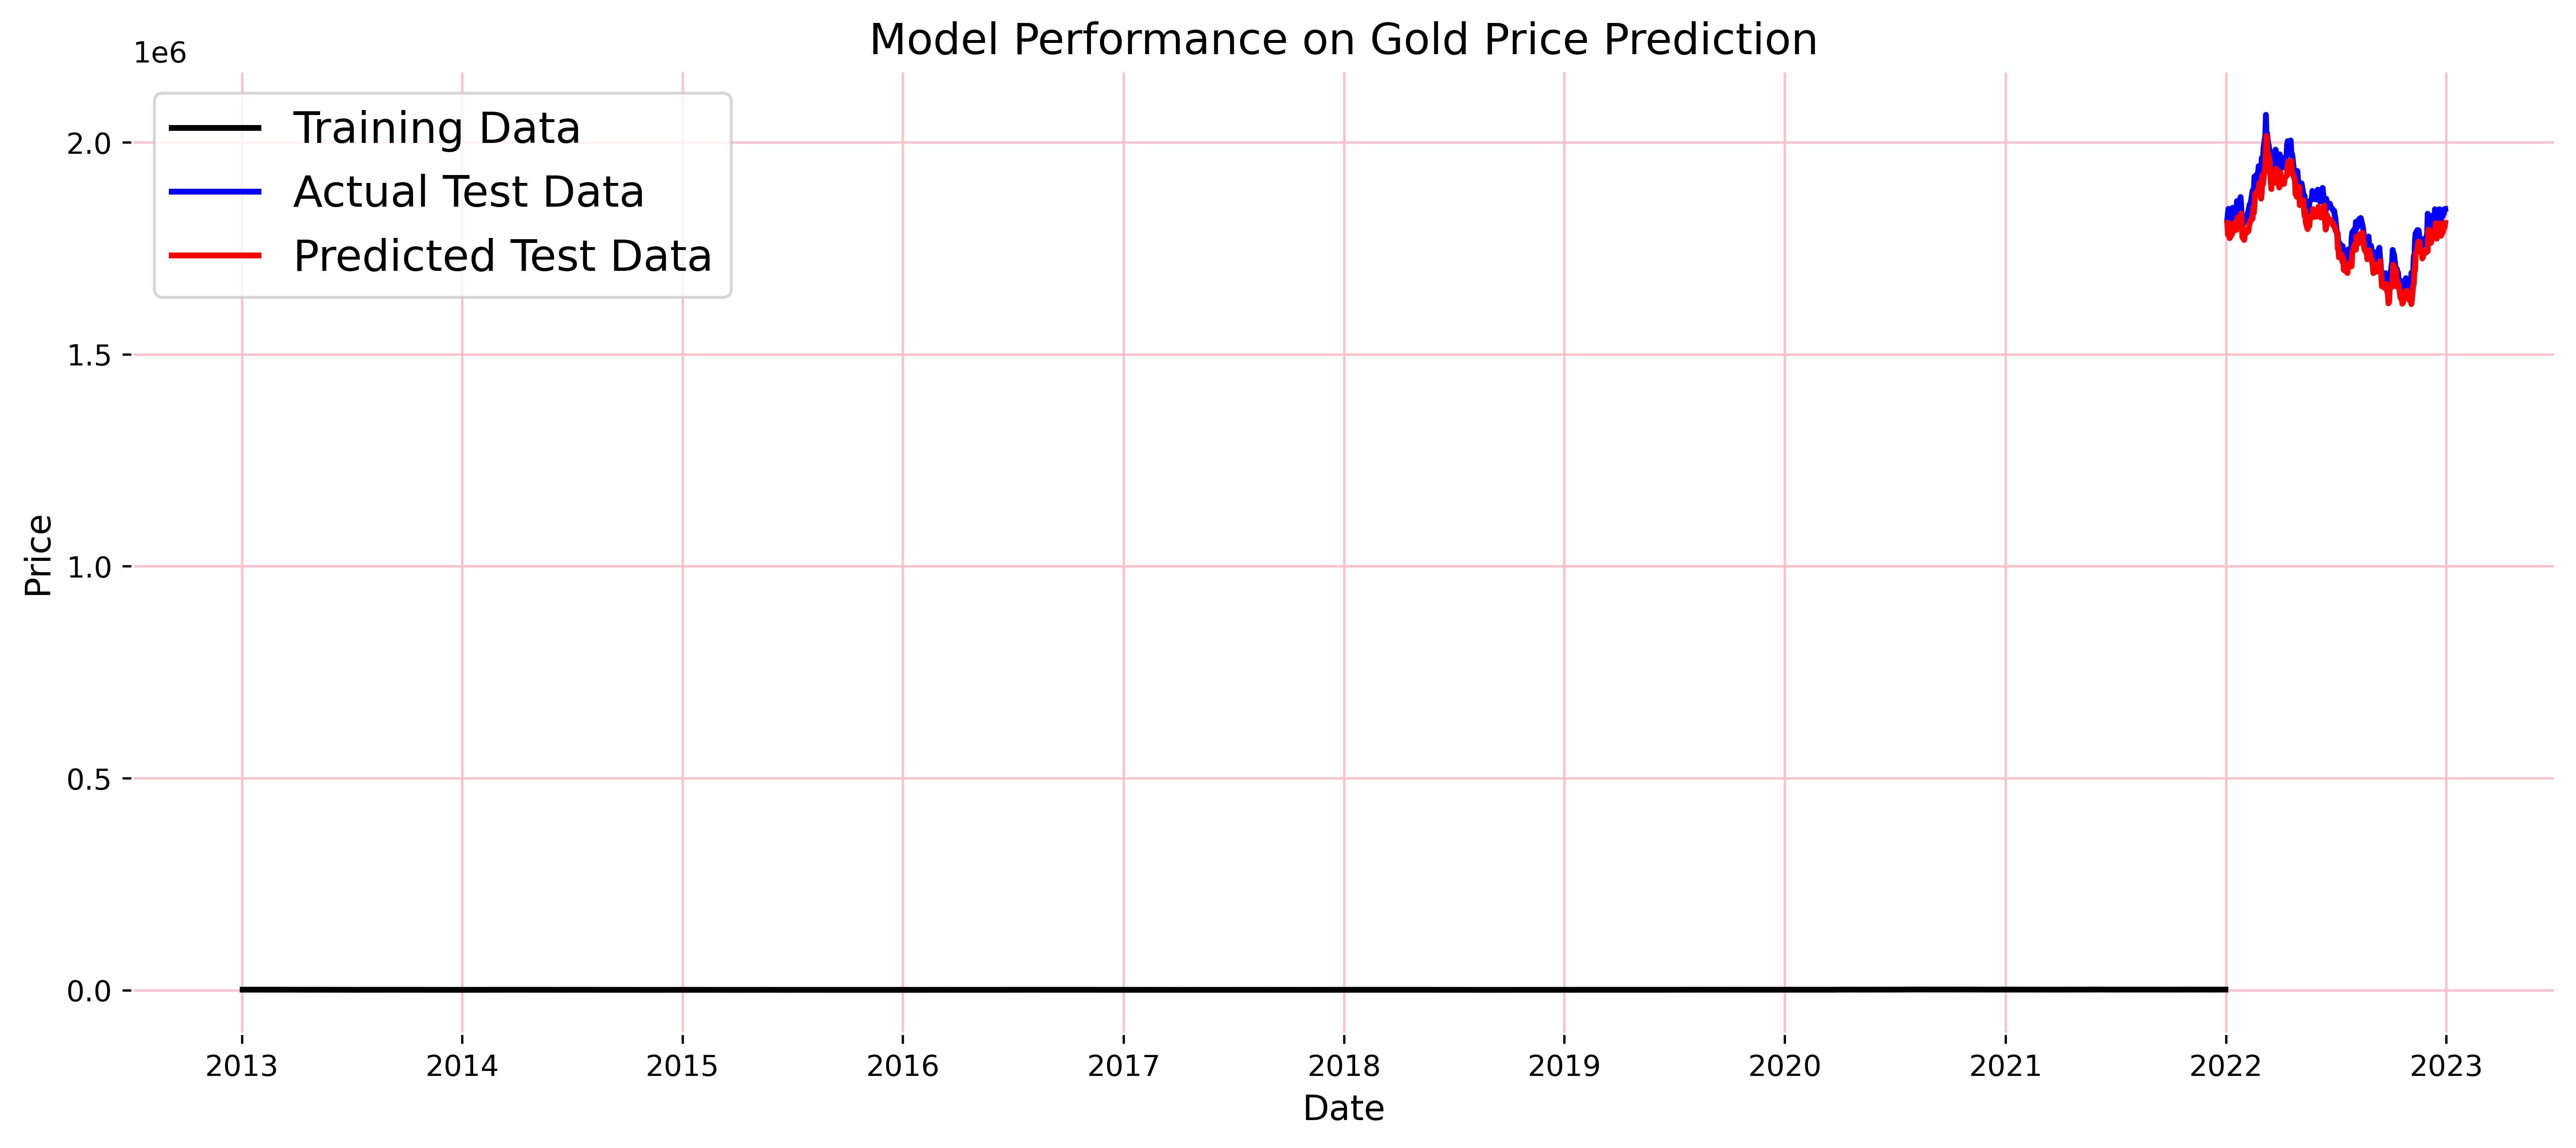

Visualization data saved to CSV.


In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Gold Price (2013-2023).csv'

df = pd.read_csv('/content/drive/MyDrive/Gold Price (2013-2023).csv')

df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

test_size = df[df.Date.dt.year == 2022].shape[0]

scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1, 1))

window_size = 60
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1, 1))
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

test_data = df.Price[-test_size - 60:]
test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

# Extracting the training and test data
train_dates = df.Date[:-test_size]
train_prices = df.Price[:-test_size]

test_dates = df.Date[-test_size:]
test_prices = df.Price[-test_size:]

# Creating DataFrames for training and test data
train_df = pd.DataFrame({'Date': train_dates, 'Price': train_prices})
test_df = pd.DataFrame({'Date': test_dates, 'Price': test_prices})

# Saving to CSV files
train_df.to_csv('/content/drive/MyDrive/Gold_Price_Training_Data.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Gold_Price_Test_Data.csv', index=False)

print("Training and test data have been saved to CSV files.")

# Defining the transformer model
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads, embed_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.pos_encoding = self.positional_encoding(window_size, embed_dim)
        self.encoder_layers = [tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim) for _ in range(num_layers)]
        self.dropout_layers = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.norm_layers = [tf.keras.layers.LayerNormalization(epsilon=1e-6) for _ in range(num_layers)]
        self.dense = tf.keras.layers.Dense(1)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x += self.pos_encoding[:, :seq_len, :]
        for i in range(len(self.encoder_layers)):
            attn_output = self.encoder_layers[i](x, x)
            attn_output = self.dropout_layers[i](attn_output)
            x = self.norm_layers[i](x + attn_output)
        x = self.dense(x[:, -1, :])
        return x

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

num_heads = 4
embed_dim = 64
num_layers = 2

window_size = X_train.shape[1]
input_shape = (window_size, 1)

model = TransformerModel(num_heads, embed_dim, num_layers)

model.compile(optimizer='adam', loss='mse')

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluating the model
predictions = model.predict(X_test)

# Inverse transform the predictions and the true values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# Ensuring y_pred and y_test are 1-dimensional arrays
predictions = np.squeeze(predictions)
y_test = np.squeeze(y_test)

# Calculating MAPE and Accuracy
MAPE = mean_absolute_percentage_error(y_test, predictions)
Accuracy = 1 - MAPE

print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

# Reshape y_test to a 2D array for inverse transformation
y_test = y_test.reshape(-1, 1)

# Inverse transform y_test and y_pred
y_test_true = scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Plot results
plt.figure(figsize=(15, 6), dpi=500)
plt.rcParams['axes.facecolor'] = 'white'  # Changed to white
plt.rc('axes', edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], predictions, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='pink')  # Changed grid color to pink
plt.show()

# Saving the visualization data to CSV
dates = df['Date'].iloc[-test_size:]
visualization_data = pd.DataFrame({
    'Date': dates,
    'Actual_Test_Data': y_test_true.flatten(),
    'Predicted_Test_Data': predictions.flatten()
})

visualization_data.to_csv('/content/drive/MyDrive/Gold_Price_Prediction_Visualization.csv', index=False)
print("Visualization data saved to CSV.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')